In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [2]:
df = pd.read_csv("aptos2019-blindness-detection/train.csv")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
class_names = df['diagnosis'].unique()
class_names

array([2, 4, 1, 0, 3], dtype=int64)

In [4]:
id_codes = df['id_code'].tolist()
random_image_id = random.choice(id_codes)

diagnosis_mapping = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

id_codes = df['id_code'].tolist()

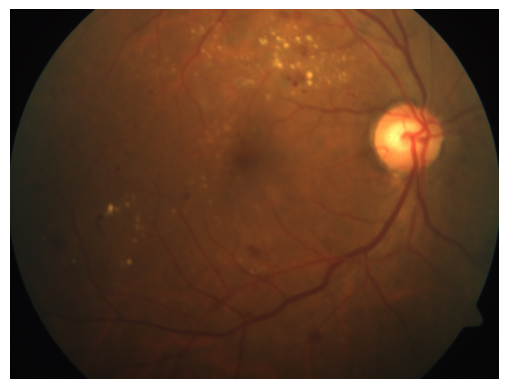

The diagnosis for 917f76f360b6 is: Moderate


In [5]:
random_image_id = random.choice(id_codes)

image_path = os.path.join('aptos2019-blindness-detection/train_images', f'{random_image_id}.png')

if os.path.exists(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

    diagnosis_code = df[df['id_code'] == random_image_id]['diagnosis'].values[0]
    
    diagnosis = diagnosis_mapping[diagnosis_code]
    
    print(f"The diagnosis for {random_image_id} is: {diagnosis}")
else:
    print(f"Image {random_image_id}.png not found in the test_images directory.")

# EDA

In [6]:
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Columns: {df.columns.tolist()}")
print(df.info())
print(df.describe())

Dataset Shape: (3662, 2)
Dataset Columns: ['id_code', 'diagnosis']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB
None
         diagnosis
count  3662.000000
mean      1.126980
std       1.298409
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       4.000000


In [7]:
print(f"Missing Values:\n{df.isnull().sum()}")

Missing Values:
id_code      0
diagnosis    0
dtype: int64


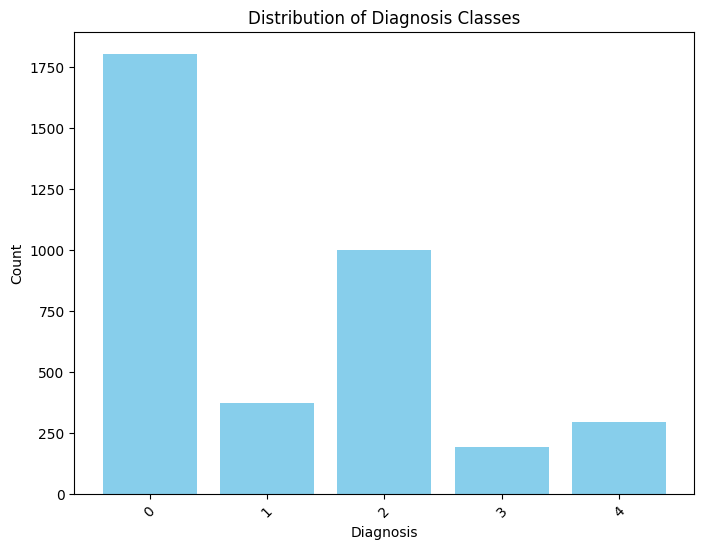

In [8]:
class_counts = df['diagnosis'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Distribution of Diagnosis Classes')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
diagnosis_percentage = df['diagnosis'].value_counts(normalize=True) * 100
print(f"Diagnosis Distribution (%):\n{diagnosis_percentage}")

Diagnosis Distribution (%):
diagnosis
0    49.290005
2    27.280175
1    10.103768
4     8.055707
3     5.270344
Name: proportion, dtype: float64


# Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from PIL import Image

In [11]:
def load_and_preprocess_image(image_id, folder):
    image_path = os.path.join(f"aptos2019-blindness-detection/{folder}/", f'{image_id}.png')
    if os.path.exists(image_path):
        img = Image.open(image_path).convert('RGB')  
        img = img.resize(image_size)  
        img_array = np.array(img) / 255.0  
        return img_array
    else:
        print(f"Image {image_id}.png not found.")
        return None

In [12]:
image_size = (128, 128)  
batch_size = 32          
num_classes = 5 

In [13]:
images = []
labels = []

for index, row in df.iterrows():
    image_id = row['id_code']
    diagnosis = row['diagnosis']
    image = load_and_preprocess_image(image_id, 'train_images')
    
    if image is not None:
        images.append(image)
        labels.append(diagnosis)

images = np.array(images)
labels = np.array(labels)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Densenet201

In [15]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

num_classes = 5  

base_model = DenseNet201(include_top=False, weights=None, input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=(128, 128, 3), name="input_layer"),
    base_model,
    layers.GlobalAveragePooling2D(name="global_average_pooling"),  
    layers.Dense(1024, activation='relu'), 
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax', name='output_layer')  
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,967,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,294,213 (77.42 MB)

 Trainable params: 1,972,229 (7.52 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [16]:
batch_size = 32
epochs = 20
input_shape = (128, 128, 3)  

history = model.fit(
    X_train,       
    y_train,       
    validation_data=(X_val, y_val),  
    epochs=epochs,      
    batch_size=batch_size  
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 699ms/step - accuracy: 0.4572 - loss: 1.3460 - val_accuracy: 0.4925 - val_loss: 1.2782
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 662ms/step - accuracy: 0.5077 - loss: 1.2503 - val_accuracy: 0.4925 - val_loss: 1.2045
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 592ms/step - accuracy: 0.5039 - loss: 1.2252 - val_accuracy: 0.4925 - val_loss: 1.1915
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 579ms/step - accuracy: 0.5183 - loss: 1.1975 - val_accuracy: 0.4939 - val_loss: 1.1763
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 614ms/step - accuracy: 0.5353 - loss: 1.1425 - val_accuracy: 0.5457 - val_loss: 1.1188
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 597ms/step - accuracy: 0.5662 - loss: 1.1269 - val_accuracy: 0.4925 - val_loss: 1.2755
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 982ms/step - accuracy: 0.5486 - loss: 1.1585 - val_accuracy: 0.6098 - val_loss: 1.0753
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5809 - loss: 1.0941 - val_accurac

In [17]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 825ms/step - accuracy: 0.6659 - loss: 1.0108
Validation Loss: 0.98272305727005
Validation Accuracy: 0.6657571792602539


In [18]:
test = pd.read_csv("aptos2019-blindness-detection/test.csv")
test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


# Edit 1

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

num_classes = 5  

base_model = DenseNet201(include_top=False, weights=None, input_shape=(128, 128, 3))
base_model.trainable = False

edit1 = models.Sequential([
    layers.Input(shape=(128, 128, 3), name="input_layer"),
    base_model,  
    layers.GlobalAveragePooling2D(name="global_average_pooling"),  
    layers.Dense(1024, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(512, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax', name='output_layer')  
])

edit1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

edit1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,967,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,816,453 (79.41 MB)

 Trainable params: 2,494,469 (9.52 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [21]:
batch_size = 32
epochs = 20
input_shape = (128, 128, 3)  

history = edit1.fit(
    X_train,       
    y_train,       
    validation_data=(X_val, y_val),  
    epochs=epochs,      
    batch_size=batch_size  
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6584 - loss: 0.9951 - val_accuracy: 0.6562 - val_loss: 0.9868
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6561 - loss: 0.9832 - val_accuracy: 0.6562 - val_loss: 0.9726
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6541 - loss: 0.9753 - val_accuracy: 0.6739 - val_loss: 0.9665
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.6524 - loss: 0.9680 - val_accuracy: 0.6835 - val_loss: 0.9564
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.6557 - loss: 0.9792 - val_accuracy: 0.6685 - val_loss: 0.9554
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.6626 - loss: 0.9581 - val_accuracy: 0.6821 - val_loss: 0.9259
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6765 - loss: 0.9011 - val_accuracy: 0.6821 - val_loss: 0.9291
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.6851 - loss: 0.9112 - val_accuracy: 0.6698 - va

In [22]:
val_loss, val_accuracy = edit1.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6693 - loss: 0.9647
Validation Loss: 0.9280217289924622
Validation Accuracy: 0.6780354976654053


# Edit 2

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_accuracy',  
    save_best_only=True,  
    mode='max',  
    verbose=1  
)

In [30]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

num_classes = 5  

base_model = DenseNet201(include_top=False, weights='imagenet')
for layer in base_model.layers[:-50]: 
    layer.trainable = False

edit2 = models.Sequential([
    layers.Input(shape=(128, 128, 3), name="input_layer"),
    base_model,
    layers.GlobalAveragePooling2D(name="global_average_pooling"),
    layers.BatchNormalization(), 
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax', name='output_layer')
])

edit2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

edit2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1920)                │           7,680 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,967,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,824,133 (79.44 MB)

 Trainable params: 4,389,317 (16.74 MB)

 Non-trainable params: 16,434,816 (62.69 MB)

In [29]:
X_train = np.array(X_train)  
y_train = np.array(y_train)  

In [31]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history2 = edit2.fit(
    X_train,       
    y_train,     
    epochs=20, 
    validation_data=(X_val, y_val),  
    callbacks=[lr_scheduler, checkpoint_callback] 
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6322 - loss: 2.2750
Epoch 1: val_accuracy improved from -inf to 0.73261, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.6329 - loss: 2.2701 - val_accuracy: 0.7326 - val_loss: 1.5209 - learning_rate: 0.0010
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7825 - loss: 1.3453
Epoch 2: val_accuracy improved from 0.73261 to 0.76535, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7824 - loss: 1.3452 - val_accuracy: 0.7653 - val_loss: 1.2716 - learning_rate: 0.0010
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7950 - loss: 1.1753
Epoch 3: val_accuracy improved from 0.76535 to 0.78990, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7948 - loss: 1.1753 - val_accuracy: 0.7899 - val_loss: 1.1756 - learning_rate: 0.0010
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8032

In [33]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7855 - loss: 1.3105
Validation Loss: 1.2064845561981201
Validation Accuracy: 0.7912687659263611
